In [94]:
import time
from numpy import cos, pi, exp, e, sqrt
import numpy
from numba import njit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [95]:
n_args_count_ = 2  # количество x-ов, подаваемых в тестовую функцию
iter_max_ = 500  # больше 500 не нужно
number_of_agents_ = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight_ = 100  # максимальный вес рыбы

##Реализация алгоритма

In [96]:
@njit
def main_function(n_args_count, iter_max, number_of_agents, max_weight):
    y = 5

    step_ind = numpy.zeros(iter_max)
    step_vol = numpy.zeros(iter_max)
    p_qbest_list = numpy.zeros((iter_max, n_args_count))  # массив p_qbest в разные моменты поколений
    w = numpy.zeros((iter_max, number_of_agents))
    P = numpy.zeros((iter_max, number_of_agents, n_args_count))  # Начальная популяция
    F = numpy.zeros((iter_max, number_of_agents))  # значение функции для каждого агента

    t = 0  # текущий номер поколения
    step_ind[t] = 0.05
    step_vol[t] = 0.05
    w[t] += max_weight / 2
    P[t] = generate_agents(number_of_agents, n_args_count)  # Случано сгенерированное текущее поколение

    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list[t] = p_qbest

    f_t = numpy.zeros(number_of_agents)
    for i in range(number_of_agents):
        f_I = f(P[t][i])
        f_t[i] = f_I
        # f_t.append(f_I)

    # значение функции для каждого агента
    F[t] = f_t

    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind[t] = step_ind[0] * exp(-y * t / iter_max)
        step_vol[t] = step_vol[0] * exp(-y * t / iter_max)

        P[t] = numpy.copy(P[t - 1])
        w[t] = numpy.copy(w[t - 1])
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]) != 0:
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        delta_F = F[t] - F[t - 1]
        for i in range(number_of_agents):
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = numpy.sum(P_mul_F[:][j])
            I_t[j] = s
        I_t /= numpy.sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = numpy.sum(w[t])
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if numpy.sum(w[t]) > numpy.sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        p_qbest_list[t] = p_qbest

    return p_qbest_list

In [97]:
def draw_graphic(f_val, functon_name, iter_max):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [98]:
def draw_distribution_graphic(best_values, function_name):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    plt.plot(numpy.arange(10), numpy.zeros(10), c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10) - 2,
                     numpy.zeros(10) + 2,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [99]:
def start_test(function_name, n_args_count, iter_max, number_of_agents, max_weight):
    best_qbest_tests = list()  # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function(n_args_count, iter_max, number_of_agents, max_weight)
        best = best_lst[-1]
        end = time.time() - start
        best_qbest_tests.append(f(best))
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        f_val = [f(i) for i in best_lst]
        draw_graphic(f_val, function_name, iter_max)
    draw_distribution_graphic(best_qbest_tests, function_name)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [100]:
@njit
def f(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i * i - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [101]:
@njit
def generate_agents(number_of_agents, n_args_count):
    return numpy.random.uniform(-5.12, 5.12, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[3.01494475e-04 9.94769533e-01]
The function value of pqbest:		0.9949841817276308
Algorithm running time:			4.602336883544922 s


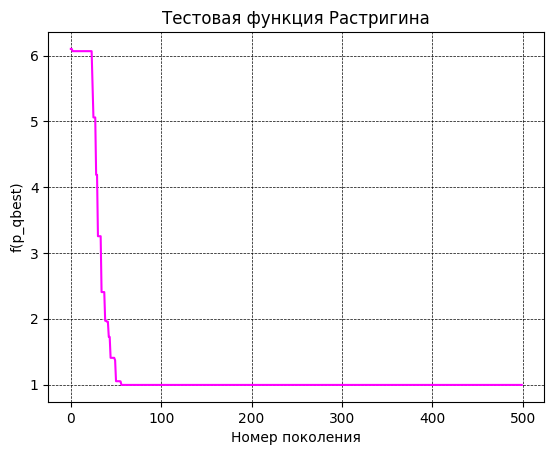

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[ 0.0188071  -0.00983942]
The function value of pqbest:		0.08929259252260735
Algorithm running time:			0.03416943550109863 s


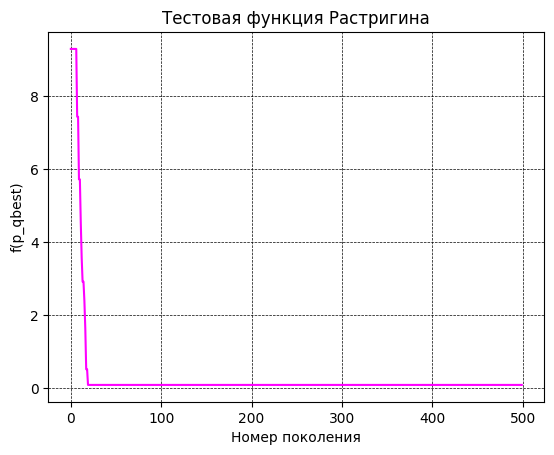

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 1.02850728 -0.06242266]
The function value of pqbest:		1.98105522945378
Algorithm running time:			0.048683881759643555 s


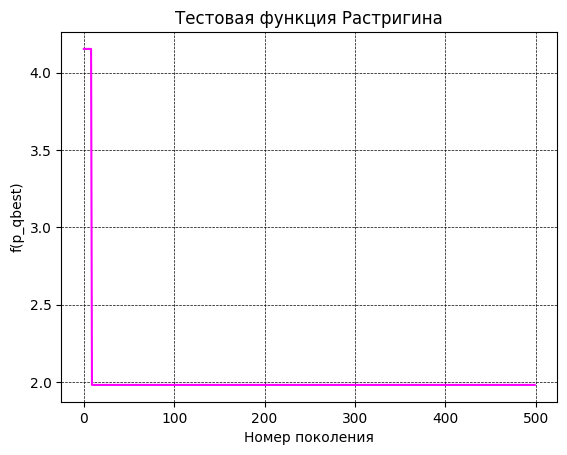

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-9.90152807e-01  6.78040989e-04]
The function value of pqbest:		0.9996282437556765
Algorithm running time:			0.05031466484069824 s


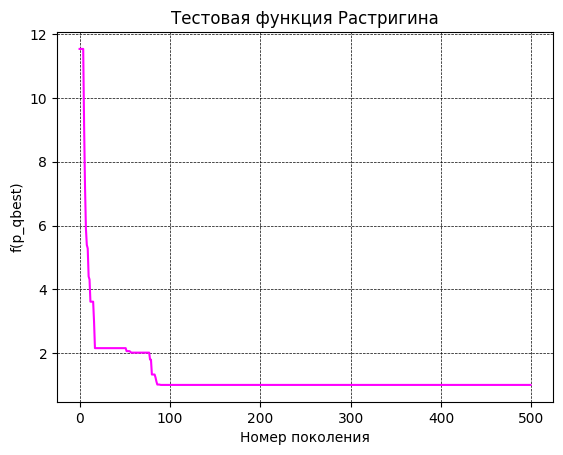

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[0.96762249 0.01651975]
The function value of pqbest:		1.1966006826414421
Algorithm running time:			0.030045032501220703 s


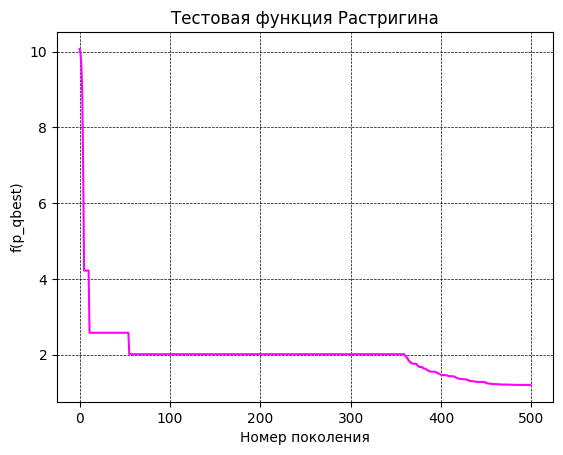

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[ 0.08965093 -1.00191439]
The function value of pqbest:		2.5575821456472667
Algorithm running time:			0.06453227996826172 s


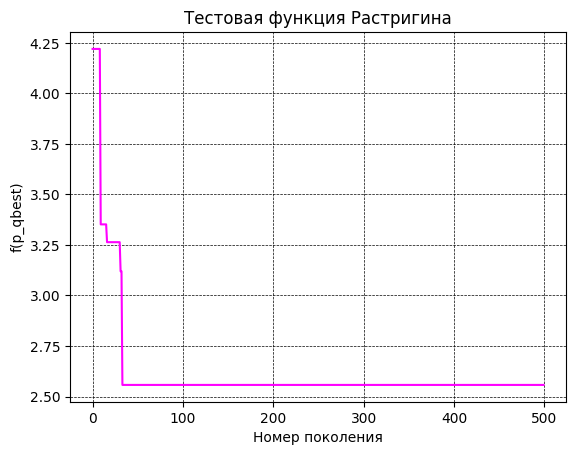

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[ 1.00224457 -0.9702236 ]
The function value of pqbest:		2.1213271482252694
Algorithm running time:			0.04333615303039551 s


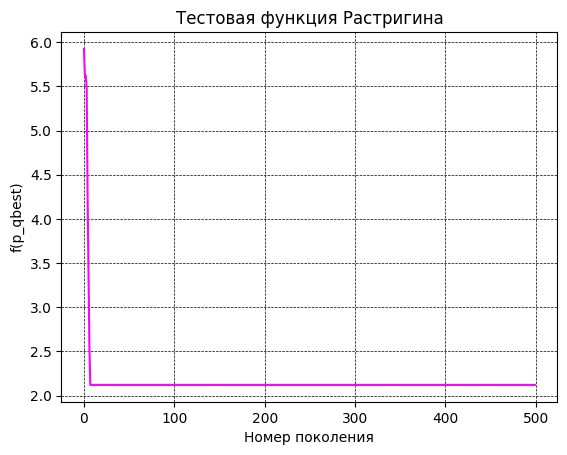

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[ 0.0936489  -0.05360848]
The function value of pqbest:		2.2553561209427073
Algorithm running time:			0.03367018699645996 s


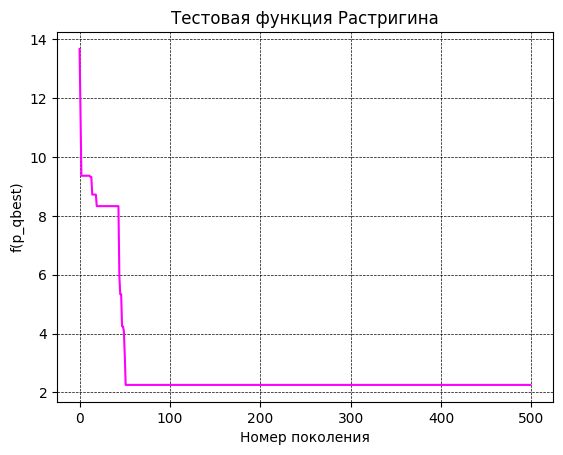

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-0.94359252 -0.01258425]
The function value of pqbest:		1.5432845681312664
Algorithm running time:			0.05534791946411133 s


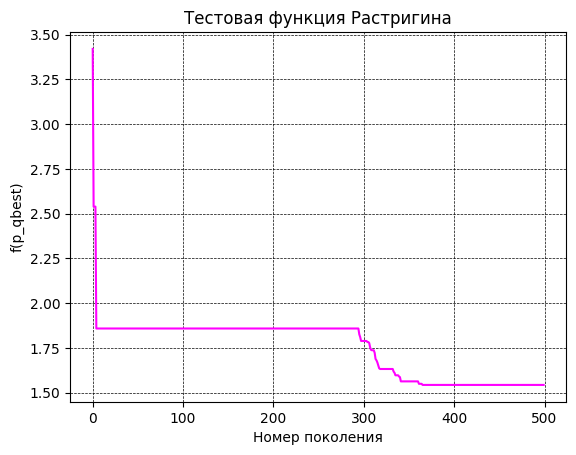

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.0018817 -1.007955 ]
The function value of pqbest:		1.0291644908319668
Algorithm running time:			0.04443025588989258 s


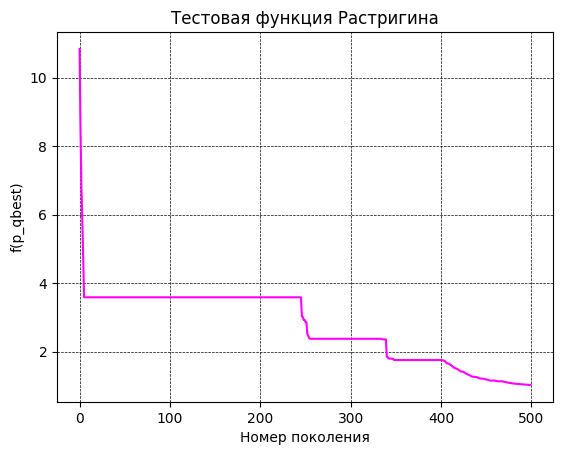

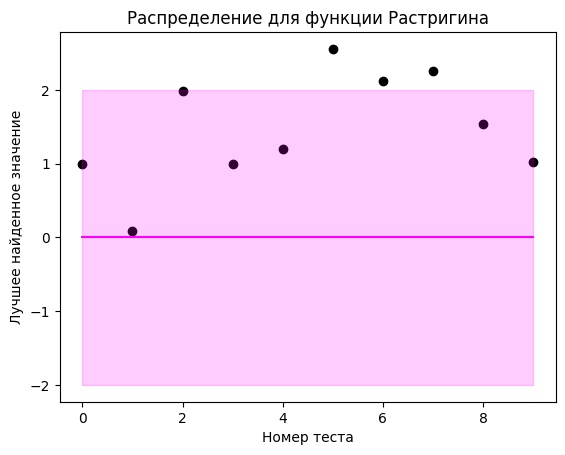

In [102]:
start_test("Растригина", n_args_count_, iter_max_, number_of_agents_, max_weight_)

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [103]:
@njit
def f(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * sqrt(0.5 * (x[0] * x[0] + x[1] * x[1]))) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [104]:
@njit
def generate_agents(number_of_agents, n_args_count):
    return numpy.random.uniform(-5, 5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-1.04428041  0.97954626]
The function value of pqbest:		3.7287828444789852
Algorithm running time:			0.03536391258239746 s


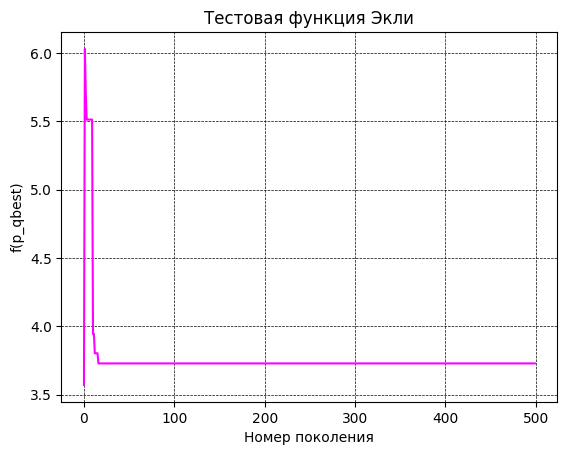

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.00772109  0.00628459]
The function value of pqbest:		0.030795752025625234
Algorithm running time:			0.02998208999633789 s


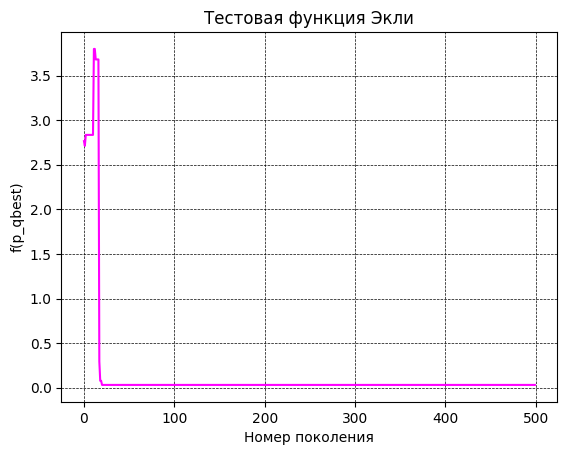

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 0.02271185 -0.00561816]
The function value of pqbest:		0.08068826134457296
Algorithm running time:			0.03191947937011719 s


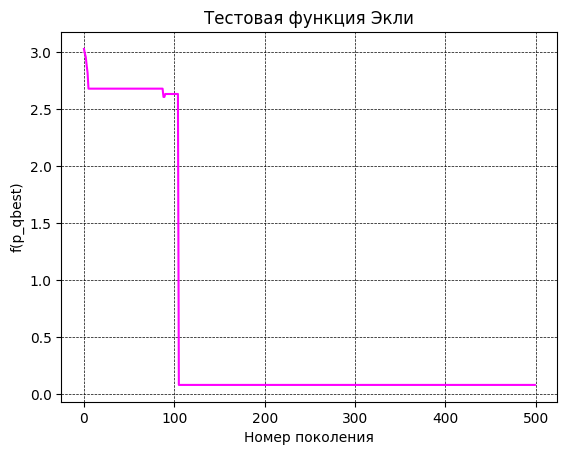

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[ 0.99675672 -0.96732072]
The function value of pqbest:		3.5955000873283716
Algorithm running time:			0.038497209548950195 s


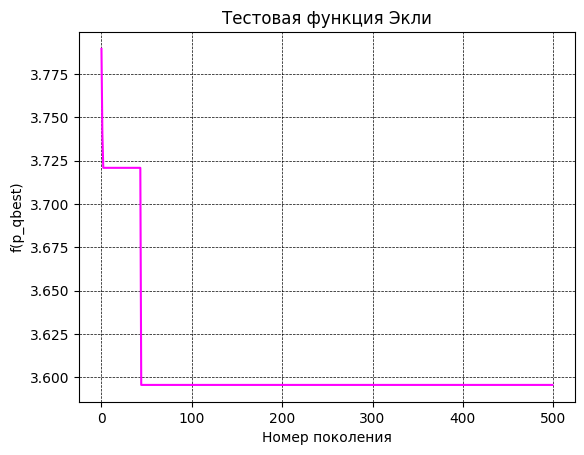

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-0.02428209  0.05976638]
The function value of pqbest:		0.2899169116081879
Algorithm running time:			0.03206491470336914 s


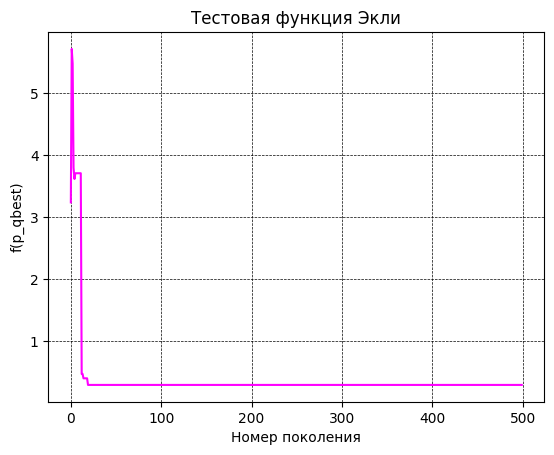

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[1.00374615 1.99010563]
The function value of pqbest:		5.41036161412239
Algorithm running time:			0.030544757843017578 s


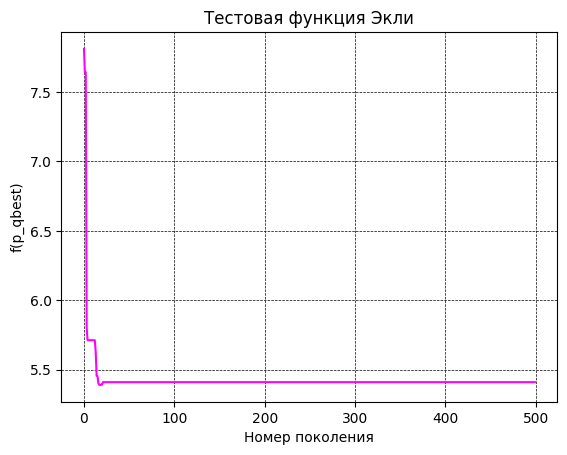

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[0.00221222 0.01752296]
The function value of pqbest:		0.05824138165185033
Algorithm running time:			0.03409743309020996 s


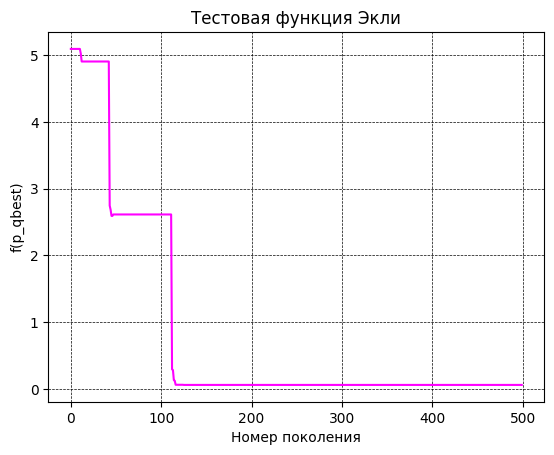

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-0.04682128  1.03827285]
The function value of pqbest:		2.829602671213962
Algorithm running time:			0.029211997985839844 s


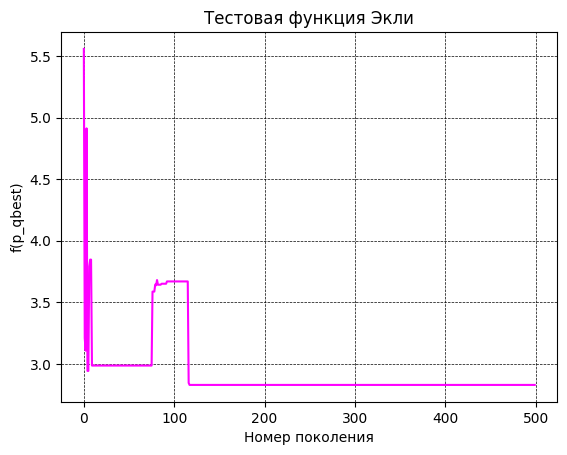

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-0.02555133  1.01938802]
The function value of pqbest:		2.713266604840541
Algorithm running time:			0.030386686325073242 s


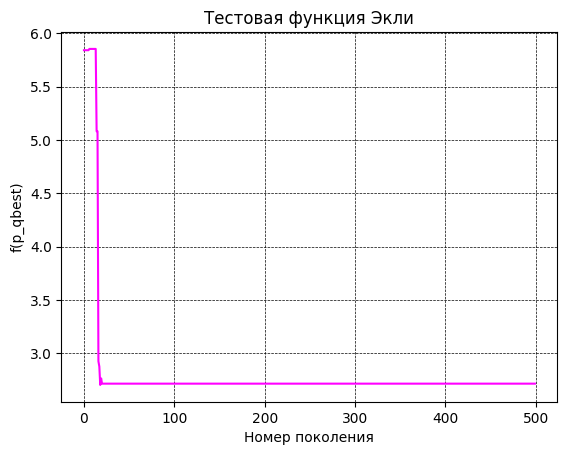

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[ 1.00296173 -0.01168955]
The function value of pqbest:		2.6488659130333794
Algorithm running time:			0.04529213905334473 s


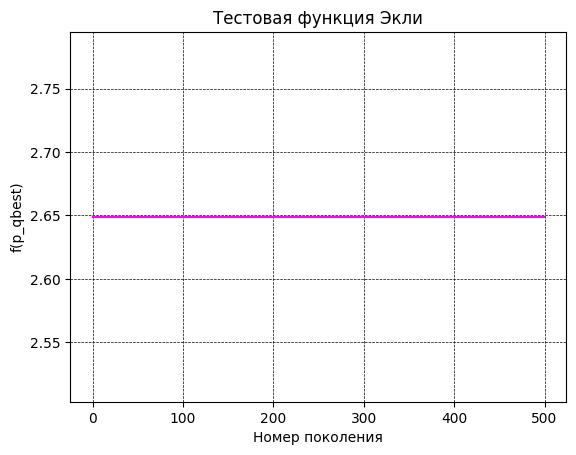

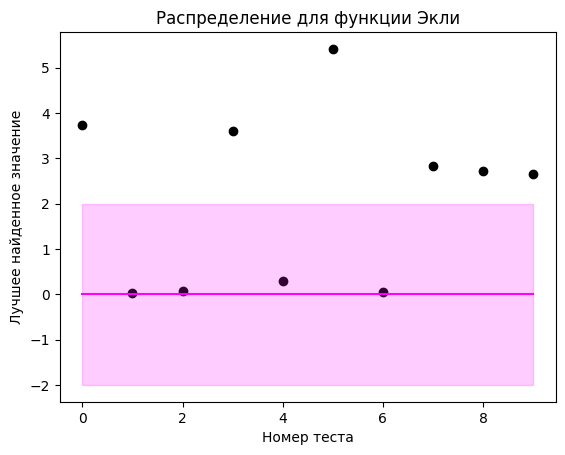

In [105]:
start_test("Экли", n_args_count_, iter_max_, number_of_agents_, max_weight_)


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [106]:
@njit
def f(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i * i
    return result

##Генерация начальных агентов

In [107]:
@njit
def generate_agents(number_of_agents, n_args_count):
    return numpy.random.uniform(-10, 10, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.99255939 0.99330172]
The function value of pqbest:		1.971822458771954
Algorithm running time:			0.02064204216003418 s


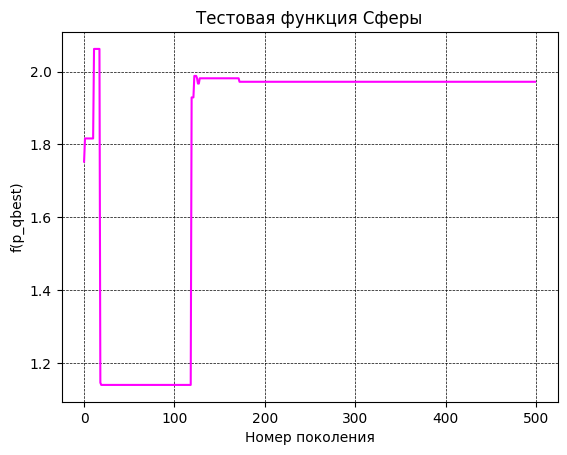

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.00950456  0.00216575]
The function value of pqbest:		9.502705371691755e-05
Algorithm running time:			0.020247220993041992 s


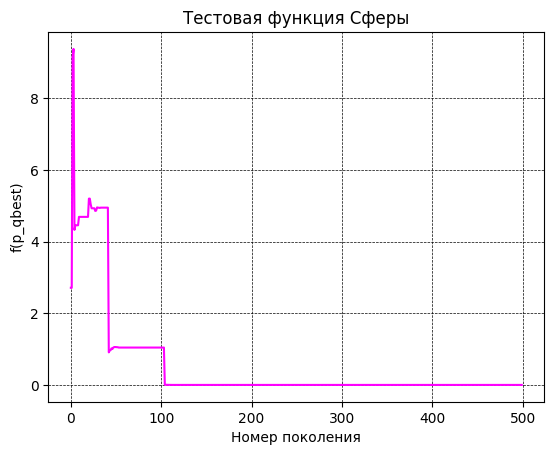

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 1.10019352 -0.98930994]
The function value of pqbest:		2.1891599500304366
Algorithm running time:			0.024952411651611328 s


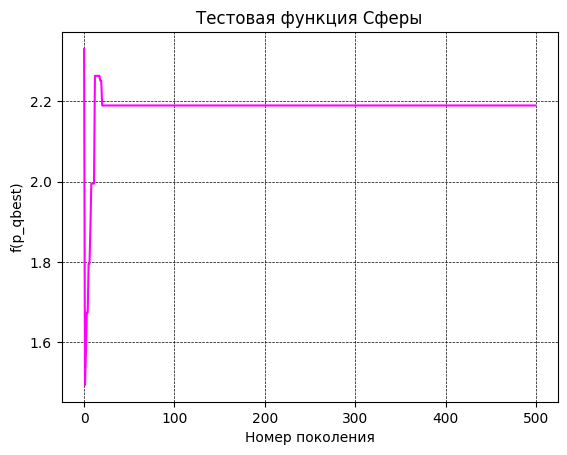

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[ 0.94567074 -0.03377642]
The function value of pqbest:		0.8954339922276736
Algorithm running time:			0.01742410659790039 s


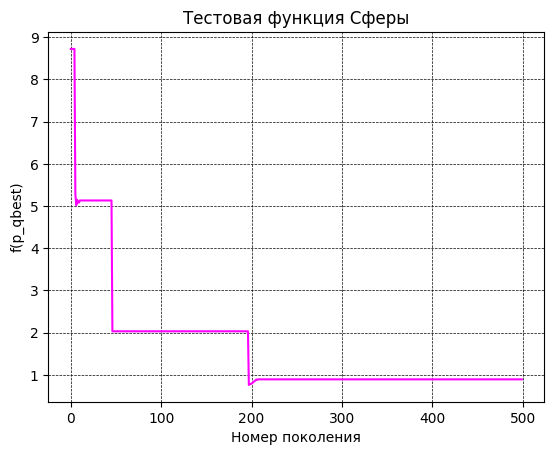

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 1.04936987 -0.97281864]
The function value of pqbest:		2.047553238109372
Algorithm running time:			0.02010655403137207 s


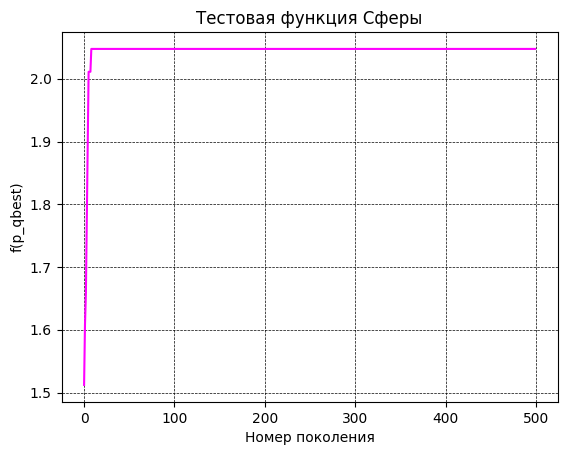

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[1.09433018 0.04560026]
The function value of pqbest:		1.1996379160410315
Algorithm running time:			0.020145654678344727 s


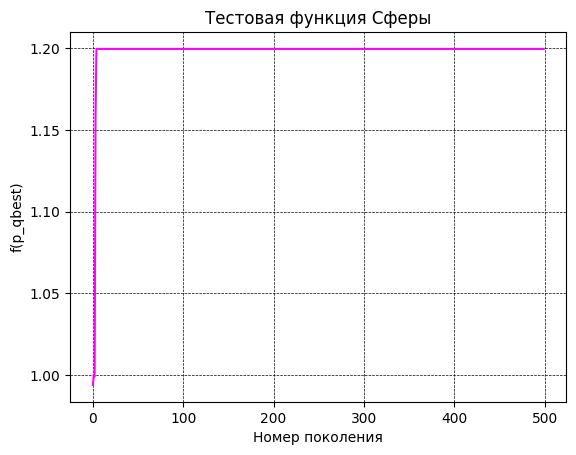

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[ 0.02369216 -1.97816894]
The function value of pqbest:		3.9137136706043405
Algorithm running time:			0.0165863037109375 s


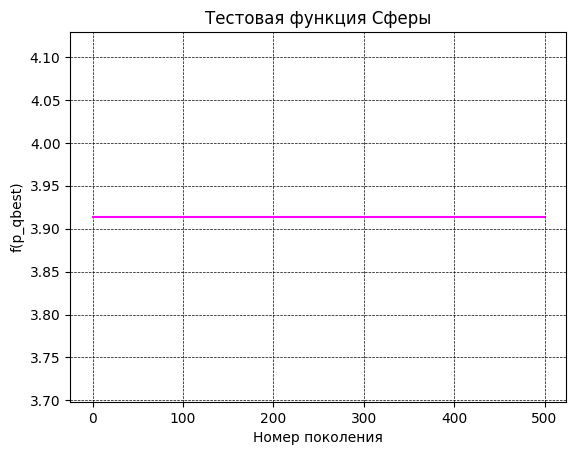

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-0.9947701  -0.99757487]
The function value of pqbest:		1.9847231624328368
Algorithm running time:			0.02008652687072754 s


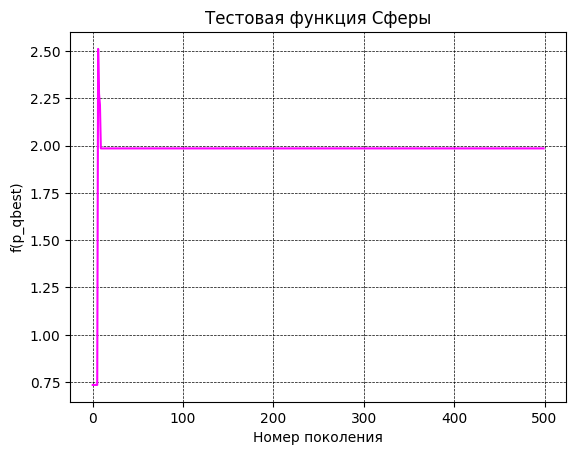

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-0.97598987  0.90930066]
The function value of pqbest:		1.7793839170736598
Algorithm running time:			0.019874095916748047 s


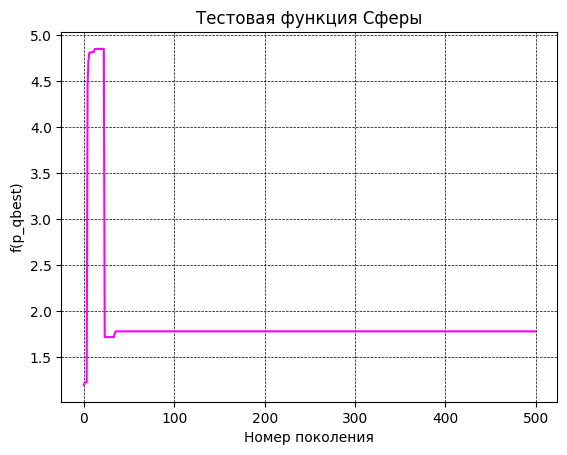

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[8.36736142e-04 9.91173110e-01]
The function value of pqbest:		0.9824248341273477
Algorithm running time:			0.024804115295410156 s


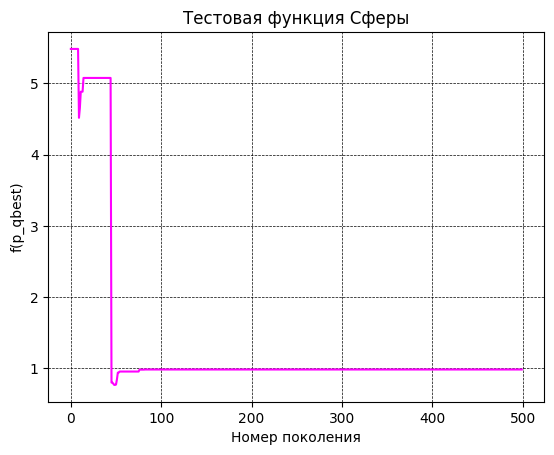

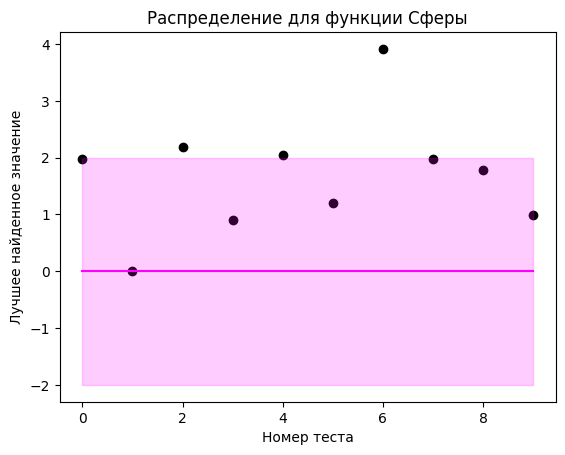

In [108]:
start_test("Сферы", n_args_count_, iter_max_, number_of_agents_, max_weight_)
